# Person classification in artworks Challenge 

---

# Done By: WASSIM BOUATAY

---

## Import the necessary libraries

In [1]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from sklearn.model_selection import train_test_split
import tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Flatten,Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential

%matplotlib inline
np.set_printoptions(precision=5)
print("Version of Tensorflow :", tensorflow.__version__)

Version of Tensorflow : 2.2.0-rc3


## Load the data from drive

In [2]:
from google.colab import drive

drive.mount('/content/drive')
!unzip -q "/content/drive/My Drive/TPT/IMA/IMA205/data.zip"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df = pd.read_csv('data/train.csv')
X_df = df['name']
y_df = df['person']
X = X_df.values
y = y_df.values

In [4]:
labels_counts_df = df.groupby('person').count()
labels_counts_df = labels_counts_df.rename(columns={'person': 'count'})
labels_counts_df

,name
person,
0,3551
1,1449


We can see clearly that the distribution of our dataset isn't balanced.

## Visualize some samples

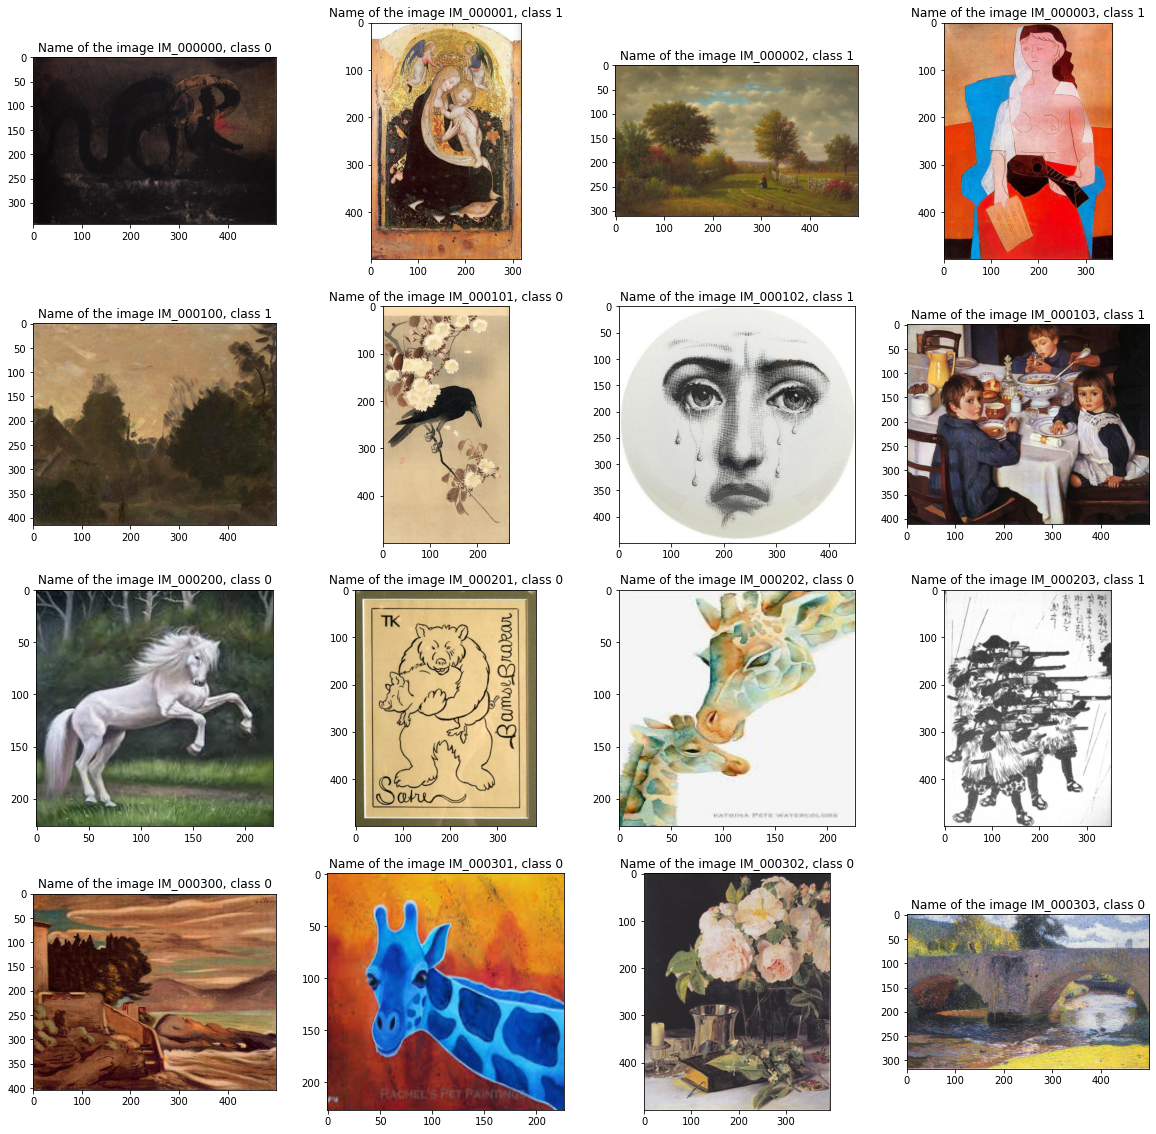

In [5]:
plt.rcParams['figure.figsize'] = [20, 20]
fig, axs = plt.subplots(4,4)
for i in range(4):
  for j in range(4):
    index = 100*i + j
    filename = 'data/im/{}.jpg'.format(X[index])
    image = imread(filename)
    axs[i, j].imshow(image)
    axs[i, j].set_title('Name of the image {0}, class {1}'.format(X[index],y[index]))

From the first view of some samples we can see that:

* Some images have multiple persons like image 103 and 203
* Some images persons are very small in the image like  image 2 and 100.
* Some images only show the face like image 102.
* We need complex features, because we have animals in a lot of the paintings. So, simple features like hands, legs and eyes are not enough to detect a person.
* It also obvious that our images have different sizes.

## Train-Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=35)
print("Number of train samples", y_train.shape[0])
print("Number of test  samples", y_test.shape[0])

Number of train samples 3750
Number of test  samples 1250


## Load images

The CNN expect images of the same size. So, I need to fixe a shape for all the images which is 400x400x3. 

Due to the limited resources (Colab provide only 25GB of RAM) it is impossible to load the images with that size without crashing the RAM. So to overcome this problem, I forced the type of the numpy arrays of the images to **float32** instead of the default **float64**, and so I was able to reduce the memory usage by a half. 

At first, I worked with images of size 200x200x3. This gave me around 89% on the validation set. But, I noticed that a lot of the mistakes made by my model back then was for images where the person is too small in the painting. So, using a relatively small image isn't enough to accurately predict this category of images. Thus, I started increasing the size of the images that I am feeding to my model. **The bigger the images the better the accuracy**. And finally, with the size 400x400x3, I reached **94% on the validation set**.

In [0]:
## fixe the shape for all the images
shape = (400,400,3)

train_Images = []
for i in range(X_train.shape[0]):
  filename = 'data/im/{}.jpg'.format(X_train[i])
  image = imread(filename).astype('float32')
  image = resize(image, shape, mode='reflect')
  train_Images.append(image)
train_Images = np.array(train_Images)

test_Images = []
for i in range(X_test.shape[0]):
  filename = 'data/im/{}.jpg'.format(X_test[i])
  image = imread(filename).astype('float32') ## Reading images as ndarrays of type float32
  image = resize(image, shape, mode='reflect')
  test_Images.append(image)
test_Images = np.array(test_Images)

## Create the model

As it was mentioned in the references provided in the website of the challenge on Kaggle, extracting features with CNN models give better result than extracting the features with SIFT. Thus, for this challenge, I used a CNN model.

**Paintings are more complicated than real-life images**. Humans have different shapes and colors, and many other paintings can be misleading with different objects that may look like humans even from a human's perspective let alone from the perspective of a CNN model. So, the only solution is to create a **deep and large model** in order to be able to extract significant features and goes beyond the performance of a human.

The problem we have here is that we have only 5000 images and only 3750 images in the train-set and it would be very hard to train a deep and large model. To overcome this problem, I used **transfer learning**, as it was mentioned in the reference "OBJECT RECOGNITION IN ART DRAWINGS: TRANSFER OF A NEURAL NETWORK". I took the **InceptionResNetV2 model provided by Keras** (without the ANN part).

As the idea of transfer learning is to use weights of the model trained with a bigger dataset, I left most the layers frozen (not trainable) and **I trained few layers of the top** so that my solution adapts with the particular type of images in my dataset (paintings). Then, I added my own ANN in which I included Dropout layers to avoid overfitting the model as much as possible as well as a Batch Normalization layer to accelerate the training of the network.

**Compiler :** I used the optimizer **Adam** which is very known for classification problems. For the loss function I used the typical loss function for binary classification problems which is **binary_crossentropy**

In [0]:
from tensorflow.keras.optimizers import Adam

def create_model(dropout_rate=0.0, lrate=0.00006, unfrozen_layers = 10):
  # load the "InceptionResNetV2" from keras.applications
  prior = tensorflow.keras.applications.InceptionResNetV2(include_top=False, 
                                             weights='imagenet',
                                             input_shape=shape)
  model = tensorflow.keras.Sequential()
  model.add(prior)
  # Add my own ANN
  model.add(Flatten()) 
  model.add(Dense(192, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(dropout_rate))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  #  Unfroze the top "unfrozen_layers"
  #  Where, unfrozen_layers is the number of layers to train
  cpt = 0
  for cnn_block_layer in model.layers[0].layers:  
    if (cpt>=unfrozen_layers):
      cnn_block_layer.trainable = False
      cpt = cpt+1
    else:
      cnn_block_layer.trainable = True

  # Compile model
  model.compile(optimizer=Adam(lr=lrate),
               loss='binary_crossentropy',
               metrics=['accuracy'])
  
  return model

As I noticed that the model overfits after few layers, I used **earlystopping** to avoid this problem and to **restore the best weights** along the training process.

In [0]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_accuracy', mode='auto', 
                           restore_best_weights = True, patience = 5)

calls = [early_stop]

### Tunning

The following block was used to tune the model. Again and due to the problem of the limited resources, it wasn't possible to use the cross-validation technic, and so I used a hard-coding equivalent technic.

First, the parameters to tune were the number of unfrozen layers, the drop rate, and the learning rate. For each parameter, I took 3 possible values (or more), and for each possible value, I created 3 or 4 models and I took the average accuracy (because of the variance of the model). Then after choosing the best value, I take other possible values until I get the "best parameter".

The batch size was chosen very small (8) because otherwise, I get a "RessourceError".


In [10]:
'''
from sklearn.metrics import f1_score

unfrozen = [8, 9, 11]
drop = [0.05, 0.1, 0.15]
lr =  [0.00003, 0.00004, 0.00006]
accuracy = np.zeros(4)

for x in range(len(accuracy)):
  for i in range(4):

    # Create the model
    model = create_model(dropout_rate = x, lrate=0.00004, unfrozen_layers=9)
    batch_size = 16
    epochs = 15
    
    # Train the model
    history = model.fit(train_Images, y_train, 
                        batch_size=batch_size,
                        epochs=epochs, 
                        validation_data=(test_Images, y_test),
                        callbacks = calls)

    # Evaluate the model with the f1_score
    predic = model.predict_classes(test_Images)
    accuracy[x] += f1_score(y_test, predic, average='weighted')
accuracy /= 4
'''

"\nfrom sklearn.metrics import f1_score\n\nunfrozen = [8, 9, 11]\ndrop = [0.05, 0.1, 0.15]\nlr =  [0.00003, 0.00004, 0.00006]\naccuracy = np.zeros(4)\n\nfor x in range(len(accuracy)):\n  for i in range(4):\n\n    # Create the model\n    model = create_model(dropout_rate = x, lrate=0.00004, unfrozen_layers=9)\n    batch_size = 16\n    epochs = 15\n    \n    # Train the model\n    history = model.fit(train_Images, y_train, \n                        batch_size=batch_size,\n                        epochs=epochs, \n                        validation_data=(test_Images, y_test),\n                        callbacks = calls)\n\n    # Evaluate the model with the f1_score\n    predic = model.predict_classes(test_Images)\n    accuracy[x] += f1_score(y_test, predic, average='weighted')\naccuracy /= 4\n"

In [11]:
# Plot the average accuracy of different values for a certain parameter
'''plt.plot(drop, accuracy, '-*')
plt.ylim(top=0.95,bottom=0.85)
print(accuracy)'''

"plt.plot(drop, accuracy, '-*')\nplt.ylim(top=0.95,bottom=0.85)\nprint(accuracy)"

#### Training the model with the final tunning

Now, I fit the model with the best parameters that I have found, and I use the early stopping in the callbacks of the fitting function. 

Also, I used more than a single model, as the model have a slight variance each time. When we fuse more models, we have more stability and the predictions we make are more reliable.

In [13]:
final_model = []
for i in range(5):
  model = create_model(dropout_rate = 0.1, lrate=0.00003, unfrozen_layers=9)
  batch_size = 10
  epochs = 15

  history = model.fit(train_Images, y_train, 
                      batch_size=batch_size,
                      epochs=epochs, 
                      validation_data=(test_Images, y_test),
                      callbacks = calls)
  final_model.append(model)

Epoch 1/15
375/375 [==============================] - 162s 432ms/step - loss: 0.5185 - accuracy: 0.7440 - val_loss: 0.2886 - val_accuracy: 0.9200
Epoch 2/15
375/375 [==============================] - 159s 423ms/step - loss: 0.2558 - accuracy: 0.9267 - val_loss: 0.2127 - val_accuracy: 0.9336
Epoch 3/15
375/375 [==============================] - 158s 422ms/step - loss: 0.1588 - accuracy: 0.9555 - val_loss: 0.2396 - val_accuracy: 0.9232
Epoch 4/15
375/375 [==============================] - 158s 422ms/step - loss: 0.1102 - accuracy: 0.9723 - val_loss: 0.2368 - val_accuracy: 0.9320
Epoch 5/15
375/375 [==============================] - 158s 422ms/step - loss: 0.0789 - accuracy: 0.9789 - val_loss: 0.2967 - val_accuracy: 0.9216
Epoch 6/15
375/375 [==============================] - 158s 422ms/step - loss: 0.0610 - accuracy: 0.9827 - val_loss: 0.2880 - val_accuracy: 0.9240
Epoch 7/15
375/375 [==============================] - 159s 423ms/step - loss: 0.0482 - accuracy: 0.9885 - val_loss: 0.2996 -

## Plot the learning curves

Here, I plot the learning curves to keep track of the overfitting problem and how the validation accuracy evaluates with the number of epchos.

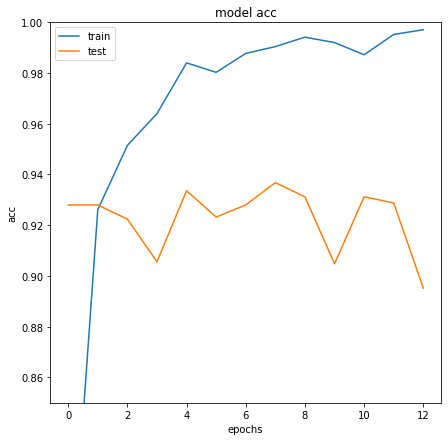

In [14]:
plt.rcParams['figure.figsize'] = [7, 7]
plt.plot(history.history['accuracy'][::])
plt.plot(history.history['val_accuracy'][::])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.ylim(top=1,bottom=0.85)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

We can see the high variablity in from history of the last model.

## Evaluate the model

#### F1-Score

Now, after I have my 5 different models, I sum the probabilities and depending on a certain threshold ( here = 2.3 ) I decide to predict 0 or 1 for every sample.

In [19]:
from sklearn.metrics import f1_score

predic = final_model[0].predict(test_Images)
for i in range(1,5):
  predic += final_model[i].predict(test_Images)

threshold = 2.3
predic[predic<=threshold] = 0
predic[predic>threshold] = 1

print(f1_score(y_test, predic, average='weighted'))

0.9417284842661542


#### Confusion matrix

In [20]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_true=y_test, y_pred=predic, normalize='true')
confusion_matrix

array([[0.97422, 0.02578],
       [0.13687, 0.86313]])

We get a very high accuracy for the majority class, a good enough accuracy for the minority class. So, we don't really have a problem of imbalanced data. My CNN model overcomed the imbalanced problem and gave a satisfying result.

#### Plot first 10 wrong predictions 

I plotted some of the wrong predictions to try to understand the type of images that the model can't handle.

True label : 0


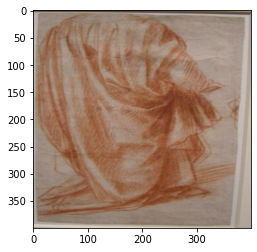

True label : 1


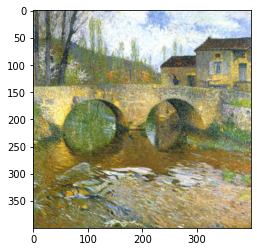

True label : 0


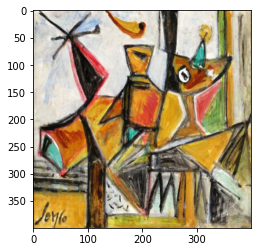

True label : 1


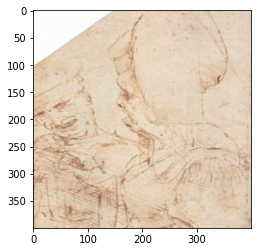

True label : 1


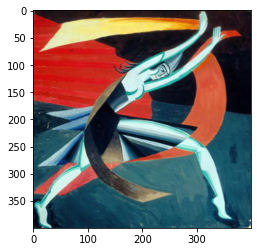

True label : 1


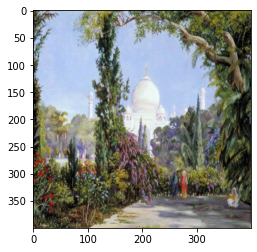

True label : 1


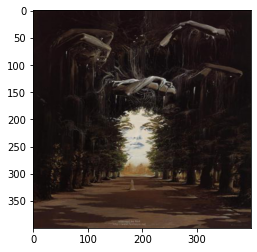

True label : 1


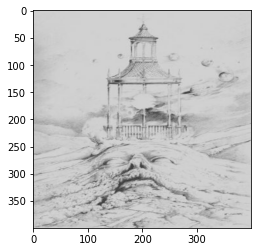

True label : 0


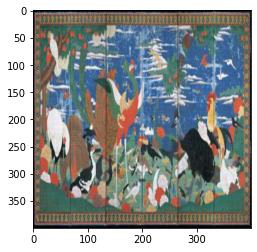

True label : 0


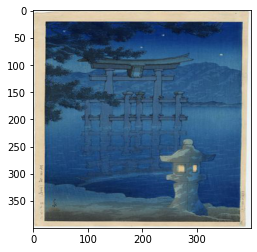

In [21]:
plt.rcParams['figure.figsize'] = [4, 4]

c = 0
for i in range(len(predic)):
  if (predic[i]!=y_test[i]):
    c += 1
    print("True label :", y_test[i])
    plt.imshow(test_Images[i]/255)
    plt.show()
    if c == 10:
      break

## Create the submission file

In [23]:
c = 0
df_submission = pd.read_csv('data/test.csv')
for Id in df_submission['name']:
    filename = 'data/im/{}.jpg'.format(Id)

    # Read the image and resize it in the same way as in the train
    image = imread(filename).astype('float32')
    image = resize(image, shape , mode='reflect')

    # Make prediction for every image
    value = 0
    for i in range(5):
      value += final_model[i].predict(np.array([image]))[0][0]
    if value<=threshold:
      value = 0
    else:
      value = 1

    df_submission.loc[df_submission['name'] == Id, 'person'] = value

    c = c+1
    if (c%100==0):
      print(c)

df_submission['person'] = df_submission['person'].astype(int) # This line is mandatory to be sure to have integer
print(df_submission.head(3))
df_submission.to_csv('data/exemple_test.csv', index=None, sep=',', mode='w') # Save the data in the exemple_test.csv file

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
        name  person
0  IM_005000       1
1  IM_005001       0
2  IM_005002       0


# Conclusion

To conclude and to put every thing together, here are the main ideas of my work in this challenge: 

* Use transfer learning because the data are very complicated and we don't have enough entries to train on, and thus we can't create our own model. So, the best possible thing is to use a pretrained model from keras.applications,  train a part of it and adjust the neural network part.
* Use dropout and early stopping to avoid overfitting.
* Semi-Manual hypertunnig due to the lack of resources.
* Use more than a single model, as the model have a slightly high variance each time.

Finally, I got around 94.2% on validation-set and 93.4% on test-set.